# MLB Outfield Fielding Analysis


---


### Load and Inspect Data


Using pyodbc, we can connect to the localhost server and MLB database to grab our prepared dataset.  More details on how this data was compiled can be found in the supplementary Jupyter notebook and SQL scripts.  The dataset contains all batted balls in play during regular season games between 2015 - 2019 in Major League Baseball (MLB).

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import pyodbc
import pandas as pd

server = **** 
database = **** 
username = **** 
password = ****
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';Trusted_Connection='+password)
cursor = cnxn.cursor()
query = 'SELECT * FROM [ods].[MLB_AllHits_export]'
AH = pd.read_sql(query, cnxn)

We can take a quick look at the columns and the descriptive statistics for the numeric ones.  A total of 638,934 records exist in this dataset.  We have some missing values in quite a few columns.  This accounts for about 0.5% of our total sample.

#### Data Dictionary
- **GamePk** - Unique Game Id for each MLB game
- **GameYear** - Season in which the corresponding game was played, 2015 to 2019
- **HalfInning** - Top or Bottom of the inning
- **PitchhandCode** - Identifies if the pitcher was left handed or right handed
- **PitchSpeed** - Velocity in miles per hour (mph) of ball thrown by pitcher
- **PitchDescription** - Type of pitch thrown, classified by MLB pitch f/x
- **BatsideCode** - Identifies if the batter was hitting left handed or right handed
- **BBType** - Type of contact from batter as classified by MLB pitch f/x
- **HitLocation** - Where the ball was hit using field positions labels 
    1. Pitcher
    2. Catcher
    3. First Base
    4. Second Base
    5. Third Base
    6. Shortstop
    7. Left Field
    8. Center Field
    9. Right Field
    
- **LaunchAngle** - Angle in degrees the batted ball left the bat, 0 being parallel to the ground
- **LauncSpeed** - Speed in mph that the batted ball left the bat
- **SprayAngle** - Angle in degrees where the batted ball left, 0 being straight center to the pitcher's mound
- **Xloc** - x-coordinate in feet (ft) where batted ball was hit to with 0 being at home plate, left negative and right positive
- **Yloc** - y-coordinate in ft where the batted ball was hit to with 0 being at home plate, behind negative and toward's center field positive
- **PlayEvent** - MLB classifiers as resulting play, for example: single, strikeout, force_out, ...
- **PlayDescription** - Free text that describes the play, typically using player names
- **LeftLine** - ft to the outfield wall along the 3rd base path
- **LeftCenter** - ft to the outfield wall at a point halfway between LeftLine and Center Field
- **Center** - ft to the outfield wall straight away from home plate through the pitcher's mound
- **RightCenter** - ft to the outfield wall at a point halfway between RightLine and Center Field
- **RightLine** - ft to the outfield wall along the 1st base path
- **LeftFielder** - Unique Id for the fielder who was playing Left Field at the time of the batted ball
- **CenterFielder** - Unique Id for the fielder who was playing Center Field at the time of the batted ball
- **RightFielder** - Unique Id for the fielder who was playing Right Field at the time of the batted ball

In [3]:
#for col in AH.columns: 
    #print(col)
    
stats = AH.describe()
print(stats)

              GamePk       GameYear     PitchSpeed    HitLocation  \
count  638934.000000  638934.000000  636806.000000  607652.000000   
mean   489493.086319    2016.981288      88.631147       6.141303   
std     54559.091652       1.415333       5.765760       2.218678   
min    413649.000000    2015.000000      45.100000       1.000000   
25%    447421.000000    2016.000000      84.700000       4.000000   
50%    491237.000000    2017.000000      89.900000       6.000000   
75%    531178.000000    2018.000000      93.000000       8.000000   
max    570335.000000    2019.000000     104.700000       9.000000   

         LaunchAngle    LaunchSpeed     SprayAngle           Xloc  \
count  622875.000000  622938.000000  637939.000000  637940.000000   
mean       11.906986      87.773313       1.189766       5.533522   
std        26.836435      13.309617      28.910188      99.513669   
min       -89.000000       5.000000     -90.000000    -307.000000   
25%        -7.000000      80.0000

### Data Transformations

Using a copy of our loaded dataset, below are a series of transformations to derive some new columns, correct some of the missing gaps, or classify variables in a more usable format. 

Bases is our dependent variable and is measureing how many bases a batter gets when he hits a ball in play.  This ranges from 0 to 4.  Types of Batted Balls have been mapped as well as the different types of pitches.  And a couple of special venues did not have LeftCenter or RightCenter measurements so an average was used to fill in.  Lastly, Outfielders were not always known; This could be researched more manually, but I put in a dummy value placeholder for the time being.

In [4]:
AHc = AH.copy()

# create new columns
AHc['Bases'] = 0 

AHc['GroundBall'] = 0
AHc['LineDrive'] = 0
AHc['FlyBall'] = 0
AHc['PopUp'] = 0

AHc['FastBall'] = 0
AHc['CurveBall'] = 0
AHc['ChangeUp'] = 0
AHc['OtherPitch'] = 0

AHc['Home'] = 0

AHc['Errors'] = 0


# logic assigned to new columns
AHc.loc[AHc.PlayEvent == 'single', 'Bases'] = 1
AHc.loc[AHc.PlayEvent == 'double', 'Bases'] = 2
AHc.loc[AHc.PlayEvent == 'triple', 'Bases'] = 3
AHc.loc[AHc.PlayEvent == 'home_run', 'Bases'] = 4
AHc.loc[(AHc.HitLocation == 10) & (AHc.PlayEvent != 'home_run')] = 2

AHc.loc[AHc.BBType == 'ground_ball', 'GroundBall'] = 1
AHc.loc[AHc.BBType == 'line_drive', 'LineDrive'] = 1
AHc.loc[AHc.BBType == 'fly_ball', 'FlyBall'] = 1
AHc.loc[AHc.BBType == 'popup', 'PopUp'] = 1

AHc.loc[AHc.PitchDescription.isin(['Fastball', 'Cutter', 'Fastball', 'Four-Seam Fastball']), 'FastBall'] = 1
AHc.loc[AHc.PitchDescription.isin(['Curveball', 'Sinker', 'Slider', 'Splitter']) , 'CurveBall'] = 1
AHc.loc[AHc.PitchDescription.isin(['Changeup', 'Two-Seam Fastball']), 'ChangeUp'] = 1
AHc.loc[AHc.PitchDescription.isin(['Eephus', 'Forkball', 'Knuckle Ball', 'Knuckle Curve', 'Screwball']), 'OtherPitch'] = 1

AHc.loc[AHc.HalfInning == 'Bot', 'Home'] = 1

AHc.loc[AHc.PlayEvent == 'field_error', 'Errors'] = 1
AHc.loc[AHc.PlayEvent == 'interf_def', 'Errors'] = 1


# clean up missing data
AHc['LeftCenter'] = AHc['LeftCenter'].fillna(0)
AHc['RightCenter'] = AHc['RightCenter'].fillna(0)

AHc.loc[AHc.LeftCenter == 0, 'LeftCenter'] = (AHc.LeftLine + AHc.Center) / 2.0
AHc.loc[AHc.RightCenter == 0, 'RightCenter'] = (AHc.RightLine + AHc.Center) / 2.0

AHc['LeftFielder'] = AHc['LeftFielder'].fillna(111111)
AHc['CenterFielder'] = AHc['CenterFielder'].fillna(111111)
AHc['RightFielder'] = AHc['RightFielder'].fillna(111111)

AHc['HitLocation'] = AHc['HitLocation'].fillna(10)

# change from categorical to numeric

AHc['Pitchhand'] = 0
AHc['Batside'] = 0

AHc.loc[AHc.PitchhandCode == 'L', 'Pitchhand'] = 1
AHc.loc[AHc.BatsideCode == 'L', 'Batside'] = 1

Dropping some columns that are no longer needed and removing 2019 from our dataset to be used later.

In [5]:
AHt = AHc.drop(columns = ['HalfInning', 'BatsideCode', 'PitchhandCode', 'BBType', 'PlayEvent', 'PlayDescription', 'PitchDescription']) 

AHd = AHt.copy()

AHa = AHd[AHd['GameYear'] == 2019]
AHd = AHd[AHd['GameYear'] != 2019]

### Plotting Data

Distribution of our independent variables, Bases, is not very uniform amongst the classes.

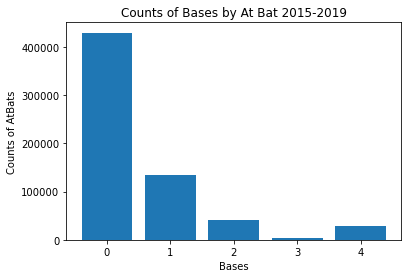

Percent Out     67 %
Percent Single  21 %
Percent Double  7 %
Percent Triple  1 %
Percent HomeRun 5 %


In [6]:
import numpy as np
import matplotlib.pyplot as plt

labels, counts = np.unique(AHt['Bases'], return_counts = True)
plt.bar(labels, counts, align = 'center')
plt.gca().set_xticks(labels)
plt.title('Counts of Bases by At Bat 2015-2019')
plt.xlabel('Bases')
plt.ylabel('Counts of AtBats')
plt.show()

Total = len(AHt)
Out = len(AHt[AHt['Bases'] == 0])
Single = len(AHt[AHt['Bases'] == 1])
Double = len(AHt[AHt['Bases'] == 2])
Triple = len(AHt[AHt['Bases'] == 3])
HomeRun = len(AHt[AHt['Bases'] == 4])
print('Percent Out    ' , round((Out/Total) *100),'%')
print('Percent Single ' , round((Single/Total) *100),'%')
print('Percent Double ' , round((Double/Total) *100),'%')
print('Percent Triple ' , round((Triple/Total) *100),'%')
print('Percent HomeRun' , round((HomeRun/Total) *100),'%')

Using Xloc and Yloc, we have a rough estimate of where a batted ball was hit to and it's outcome in number of bases.  A slight pattern is noticable.  HomeRuns in yellow exist outside of the outfield dimensions.  Bases hits seems to be mostly in between the infield and outfield or in the gaps between the outfielders. 

We can also see how MLB classifies positions too.

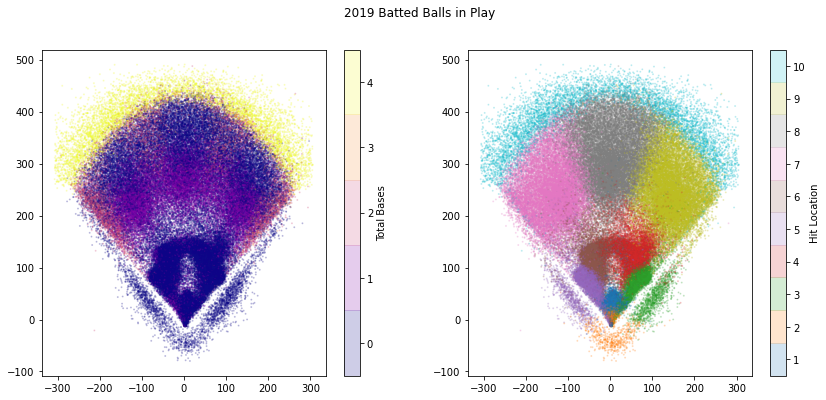

In [7]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.scatter(AHa['Xloc'], AHa['Yloc'], alpha = 0.2, c = AHa['Bases'], s = 1, cmap = plt.cm.get_cmap('plasma', 5));
plt.colorbar(ticks = range(6), label = 'Total Bases')
plt.clim(-0.5, 4.5)
plt.subplot(1,2,2)
plt.scatter(AHa['Xloc'], AHa['Yloc'], alpha = 0.2, c = AHa['HitLocation'], s = 1, cmap = plt.cm.get_cmap('tab10', 10));
plt.colorbar(ticks = range(11), label = 'Hit Location')
plt.clim(0.5, 10.5)
plt.suptitle('2019 Batted Balls in Play')
plt.show()

PitchSpeed doesn't appear to have much variance between hits and outs.  SprayAngle / Xloc shows a strong correlation down the first base side for triples.  This makes intuitive sense since it will be harder to to get the ball in front of the runner from the opposite side of the baseball field.  Yloc, LaunchSpeed, LaunchAngle all scale with bases and possibly correlated with one another.

In [8]:
Bases_means = AHd.groupby('Bases').mean()
Bases_means[['HitLocation', 'PitchSpeed', 'LaunchSpeed', 'LaunchAngle', 'SprayAngle', 'Xloc', 'Yloc']]

,HitLocation,PitchSpeed,LaunchSpeed,LaunchAngle,SprayAngle,Xloc,Yloc
Bases,,,,,,,
0,5.579174,88.546976,84.880415,11.882234,2.208375,8.232134,157.535750
1,7.344621,88.787521,90.164684,6.085310,-0.053797,5.567980,212.013291
2,7.939289,88.556481,96.741405,16.299381,-3.470656,-13.880781,277.765907
3,8.280544,88.836052,97.431298,19.362889,14.236946,77.580006,322.681020
4,9.995182,88.458719,102.859813,28.061252,-1.515494,-9.963401,370.108194


Two sets of violin plots better illustrate that PitchSpeed appears to have little impact on outcome.  It is also interesting that the range of values goes down as the bases go up.  This could partly be due to the smaller sample size, but for LaunchAngle you can see 45 degrees is the optimal for distance as evidenced by Home Runs. 

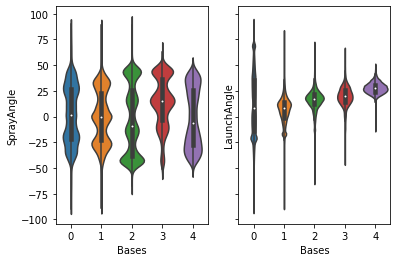

In [9]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True);
sns.violinplot(x = 'Bases', y = 'SprayAngle', data = AHd, ax = ax1);
sns.violinplot(x = 'Bases', y = 'LaunchAngle', data = AHd, ax = ax2);

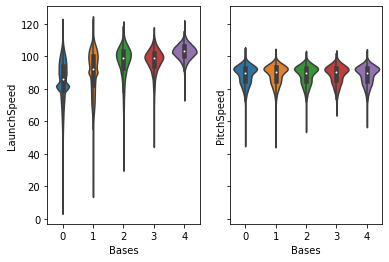

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True);
sns.violinplot(x = 'Bases', y = 'LaunchSpeed', data = AHd, ax = ax1);
sns.violinplot(x = 'Bases', y = 'PitchSpeed', data = AHd, ax = ax2);

Similarly, the type of batted ball can tell us a lot about the outcome of the hit.  PopUps are almost always outs.  A GroundBall may be a single or an out, but rarely anything else.  LineDrive is clearly the most advantageous type of hit with FlyBall leading to extra bases if it is not caught.

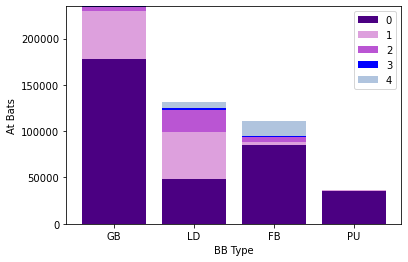

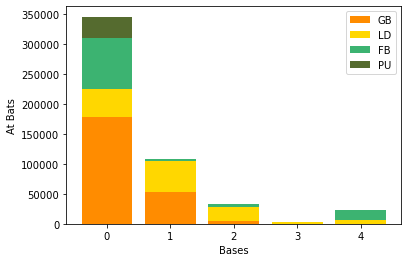

In [11]:
#H = AHd.groupby(['GroundBall', 'LineDrive', 'FlyBall', 'PopUp', 'Bases']).count()
O = np.array([177414, 48026, 84697, 35371])
S = np.array([52644, 51596, 3966, 589])
D = np.array([4443, 23701, 4828, 185])
T = np.array([261, 2195, 993, 5])
HR = np.array([0, 5786, 16423, 0])
BB = ['GB', 'LD', 'FB', 'PU']
TB = np.array([0, 1, 2, 3, 4])
PU = np.array([35371, 589, 185, 5, 0])
FB = np.array([84697, 3966, 4828, 993, 16423])
LD = np.array([48026, 51596, 23701, 2195, 5786])
GB = np.array([177414, 52644, 4443, 261, 0])

plt.bar(BB, O, color = 'indigo')
plt.bar(BB, S, bottom = O, color = 'plum')
plt.bar(BB, D, bottom = O+S, color = 'mediumorchid')
plt.bar(BB, T, bottom = O+S+D , color = 'blue')
plt.bar(BB, HR, bottom = O+S+D+T, color = 'lightsteelblue')
plt.legend(TB)
plt.ylabel('At Bats')
plt.xlabel('BB Type')
plt.show()

plt.bar(TB, GB, color = 'darkorange')
plt.bar(TB, LD, bottom = GB, color = 'gold' )
plt.bar(TB, FB, bottom = GB+LD, color = 'mediumseagreen')
plt.bar(TB, PU, bottom = GB+LD+FB , color = 'darkolivegreen')
plt.legend(BB)
plt.ylabel('At Bats')
plt.xlabel('Bases')
plt.show()

Let's drop the few records that are missing vital information and remove a few columns that won't be needed during our model creation tasks.

In [12]:
AHr = AHd.copy()

AHr = AHr.dropna(subset = ['LaunchAngle','LaunchSpeed', 'SprayAngle', 'Xloc', 'Yloc', 'PitchSpeed'])
AHr = AHr.drop(columns = ['GamePk', 'GameYear', 'LeftFielder', 'CenterFielder', 'RightFielder', 'Errors', 'Home'])

### Correlation

There's a concern that some of the features are correlated with one another a bit too much.  SprayAngle and Xloc are capturing the same thing, the left to right location of the batted ball.  Similarly, LaunchAngle appears to be a key component in how BBType was categorized.

The correlations of the field dimensions suggest that ballparks are rarely symmetrical. 

We also can note that typically pitchers and batters use opposite hands.  This tends to benefit the pitcher; The natural throwing motion with an opposite hand allows the ball to travel with a trajectory towards the batter and the inside of the plate instead of away from and the outside of the plate.  Based on the literature, balls on the inside of the plate are harder to hit for batters.  

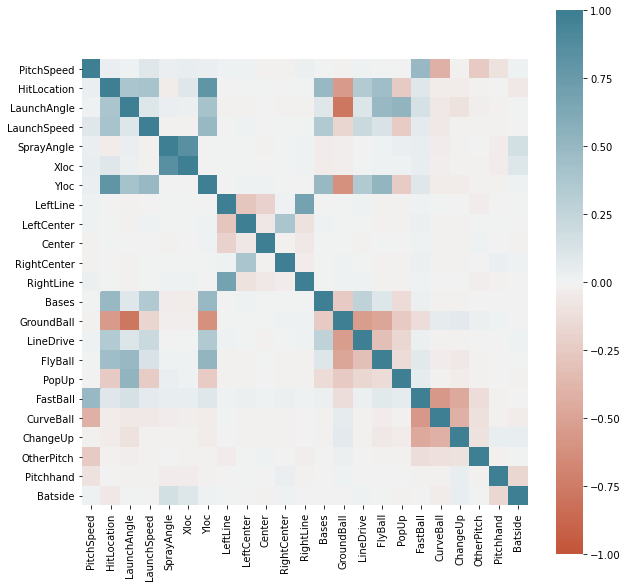

In [13]:
import seaborn as sns

corr = AHr.corr()

plt.figure(figsize = (10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Pulling out Bases and ordering the features from positive to negative correlated, we can some small inferences:

- Hitting the ball harder and with a lower trajectory tends to help increase the Bases measure.
- Bigger outfields might allow more space for batters to hit the ball away from fielders, probably at the cost of fewer natural home runs.
- Oddly, Yloc is slightly negatively correlated with Bases.  This might be because hits are more likely between the infielders and the outfielers and the ones behind the outfielders will go over the fence and not be in our study.  

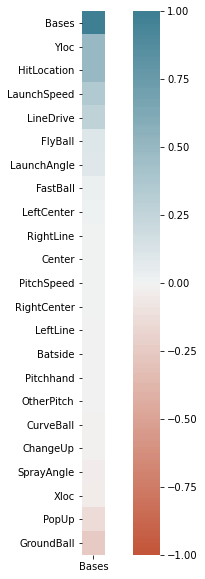

In [14]:
corr_B = corr[['Bases']]
corr_B = corr_B.sort_values(by = 'Bases',ascending=False)

plt.figure(figsize = (10,10))
ax = sns.heatmap(
    corr_B, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

### Feature Selection

Using Linear Regression, we can calculate Variance Inflation Factor to determine which columns are not needed in our dataset because they are represented by other features.  We do this by running a linear regression with one dependent variable against all the other dependent variables.  With the R Squared value, we can articulate which features can easily be estimated by others in the dataset.  This should help reduce multicollinarity in our sample data.

After our first run, our BBType classifiers and our PitchType classifiers both have very high values. We can remove these one by one and retest the model.  Ideally, we'd want to see VIF numbers less than 5 or 10 for all features. 

In [17]:
import statsmodels.api as sm

# modified from https://www.youtube.com/watch?v=qmt7ZZoiDwc
X = AHr.drop(columns = 'Bases')
Y = AHr['Bases'].to_numpy()
cols = X.columns
ind_df = pd.DataFrame(X, columns = cols)


data = []
vif_df = pd.DataFrame(data, columns = ['Feature', 'RSq', 'VIF'])


for i in range(0, len(cols)):
    y = ind_df.loc[:, ind_df.columns == cols[i]]
    X = ind_df.loc[:, ind_df.columns != cols[i]]
    model = sm.OLS(y, X)
    results = model.fit()
    rsq = results.rsquared
    vif = round (1 / (1 - rsq), 2)
    vif_df = vif_df.append({'Feature': cols[i], 'RSq':rsq, 'VIF':vif},ignore_index = True)
    
print(vif_df)

        Feature       RSq        VIF
0    PitchSpeed  0.336153       1.51
1   HitLocation  0.733056       3.75
2   LaunchAngle  0.822525       5.63
3   LaunchSpeed  0.303272       1.44
4    SprayAngle  0.764656       4.25
5          Xloc  0.767969       4.31
6          Yloc  0.768601       4.32
7      LeftLine  0.560747       2.28
8    LeftCenter  0.275653       1.38
9        Center  0.075956       1.08
10  RightCenter  0.193232       1.24
11    RightLine  0.497960       1.99
12   GroundBall  0.999996  226616.68
13    LineDrive  0.999992  131024.53
14      FlyBall  0.999991  110699.86
15        PopUp  0.999972   35995.98
16     FastBall  0.999992  118644.90
17    CurveBall  0.999991  109998.35
18     ChangeUp  0.999989   94419.25
19   OtherPitch  0.999920   12527.28
20    Pitchhand  0.046427       1.05
21      Batside  0.069706       1.07


After playing around with this process a bit more, we've reduced the features down to the following 6:
- PitchSpeed
- LaunchAngle
- LaunchSpeed
- SprayAngle
- Pitchhand
- Batside


We could also keep the following features as well but will test both models.
- HitLocation
- Xloc
- Yloc
- LeftLine
- LeftCenter
- Center
- RightCenter
- RightLine

The thought process is:
Xloc can be explained by SprayAngle and Yloc can be explained by LaunchAngle + LaunchSpeed.  
HitLocation is similarly just a calculation between Xloc and Yloc.  
BBType classifiers are a product of LaunchAngle and LaunchSpeed as well.  
All the outfield measurements probably are very similiar and may not have much impact on the model.

In [28]:
X = AHr.drop(columns = ['Bases'
             ,'LeftLine','LeftCenter','Center','RightCenter','RightLine'
             #,'FastBall', 'CurveBall', 'ChangeUp', 'OtherPitch'
             ,'GroundBall'#, 'LineDrive', 'FlyBall', 'PopUp'
             #,'Xloc'
             ,'Yloc'
             #,'Pitchhand', 'Batside'
             ,'PitchSpeed'
             ,'LaunchSpeed'
             ,'LaunchAngle'
             #,'SprayAngle'
             ,'HitLocation'           
             ])
Y = AHr['Bases'].to_numpy()
cols = X.columns
ind_df = pd.DataFrame(X, columns = cols)


data = []
vif_df = pd.DataFrame(data, columns = ['Feature', 'RSq', 'VIF'])


for i in range(0, len(cols)):
    y = ind_df.loc[:, ind_df.columns == cols[i]]
    X = ind_df.loc[:, ind_df.columns != cols[i]]
    model = sm.OLS(y, X)
    results = model.fit()
    rsq = results.rsquared
    vif = round (1 / (1 - rsq), 2)
    vif_df = vif_df.append({'Feature': cols[i], 'RSq':rsq, 'VIF':vif},ignore_index = True)
    
print(vif_df)

       Feature       RSq   VIF
0   SprayAngle  0.722448  3.60
1         Xloc  0.718101  3.55
2    LineDrive  0.370342  1.59
3      FlyBall  0.337018  1.51
4        PopUp  0.145928  1.17
5     FastBall  0.530746  2.13
6    CurveBall  0.424783  1.74
7     ChangeUp  0.394594  1.65
8   OtherPitch  0.051489  1.05
9    Pitchhand  0.289101  1.41
10     Batside  0.450044  1.82


### Logistic Regression

For our investigation, we'd like to create a model that can accurately classify bases based on hit information.  Logistic Regression is a popular choice for classification problems.  To help this process, we're going to standarize our X components using sklearn's preprocessing package.  Initial results are not great.  We specify the class weights based on the posterior probabilities of the sample to help.  More tuning is needed.

In [29]:
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as mod_sel


AHsX = AHr.drop(columns = [
  'Bases','LeftLine','LeftCenter','Center','RightCenter','RightLine','GroundBall','Yloc','PitchSpeed','LaunchSpeed','LaunchAngle','HitLocation' 
                        ])
AHsY = AHr['Bases'].to_numpy()


stand_X = preprocessing.scale(AHsX)


X_train, X_test, Y_train, Y_testAH = mod_sel.train_test_split(stand_X, AHsY, test_size = .2, random_state = 27)

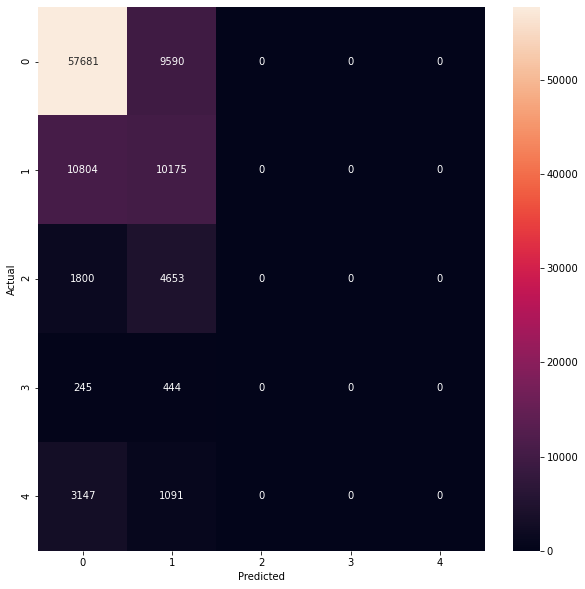

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     67271
           1       0.39      0.49      0.43     20979
           2       0.00      0.00      0.00      6453
           3       0.00      0.00      0.00       689
           4       0.00      0.00      0.00      4238

    accuracy                           0.68     99630
   macro avg       0.23      0.27      0.25     99630
weighted avg       0.61      0.68      0.64     99630



C:\Users\chweb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import sklearn.linear_model as lin_mod
import sklearn.metrics as metrics


LogReg = lin_mod.LogisticRegression(fit_intercept = 0, solver = 'lbfgs',class_weight = {0: 682, 1: 211, 2: 65, 3: 7, 4: 45} , max_iter = 400, penalty = 'l2')
LogReg.fit(X_train, Y_train)
Y_predAH = LogReg.predict(X_test) 



cm = metrics.confusion_matrix(Y_testAH, Y_predAH)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(Y_testAH, Y_predAH))

Reducing the model to only Outfield Hits to Left Field is slightly better.  Including the additional features increases the accuracy of the model by about 3% overall, but logistic regression rarely predicts anything for classes 3 or 4.

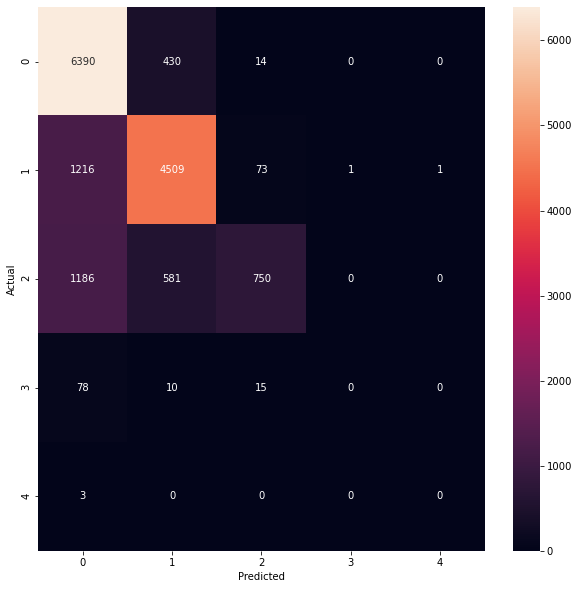

              precision    recall  f1-score   support

           0       0.72      0.94      0.81      6834
           1       0.82      0.78      0.80      5800
           2       0.88      0.30      0.45      2517
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00         3

    accuracy                           0.76     15257
   macro avg       0.48      0.40      0.41     15257
weighted avg       0.78      0.76      0.74     15257

Cohen Kappa Score          0.6008736611390001


In [31]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('always')

OH7 = AHr.copy()
OH7 = OH7[OH7['HitLocation'] == 7]

OH7X = OH7.drop(columns = ['Bases','LeftLine','LeftCenter','Center','RightCenter','RightLine','GroundBall','Yloc','PitchSpeed','LaunchSpeed','LaunchAngle','HitLocation' 
                          ])
OH7Y = OH7['Bases'].to_numpy()
cols7 = OH7X.columns

stand_X = preprocessing.scale(OH7X)

X_train, X_test, Y_train, Y_testOH7 = mod_sel.train_test_split(stand_X, OH7Y, test_size = .2, random_state = 27)

# {0: 0.682, 1: 0.211, 2: 0.065, 3: 0.007, 4: 0.045} AH
# {0: 0.493, 1: 0.367, 2: 0.126, 3: 0.014, 4: 0.000} OH
# {0: 0.682, 1: 0.377, 2: 0.166, 3: 0.006, 4: 0.000} OH7
# {0: 0.530, 1: 0.361, 2: 0.094, 3: 0.015, 4: 0.000} OH8
# {0: 0.510, 1: 0.365, 2: 0.124, 3: 0.021, 4: 0.000} OH9
LogRegOH7 = lin_mod.LogisticRegression(fit_intercept = 0, solver = 'lbfgs', class_weight = {0: 0.682, 1: 0.377 , 2: 0.166, 3: 0.006, 4: 0}, max_iter = 400, penalty = 'l2'
                                    , multi_class = 'auto')
LogRegOH7.fit(X_train, Y_train)
Y_predOH7 = LogRegOH7.predict(X_test)
Y_scoreOH7 = LogRegOH7.predict_proba(X_test)

cm = metrics.confusion_matrix(Y_testOH7, Y_predOH7)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(Y_testOH7, Y_predOH7))
print('Cohen Kappa Score         ',metrics.cohen_kappa_score(Y_testOH7, Y_predOH7))

### SMOTE

Since our dataset is so unbalanced, we can use SMOTE to balance the numbers amongst our sample, starting with hits to Left Field and then re-train our model and evaluate how the results improve.

In [32]:
from imblearn.over_sampling import SMOTE


os = SMOTE(random_state = 27)
cols7 = OH7X.columns
os_X, os_Y = os.fit_sample(X_train, Y_train)

os_X = pd.DataFrame(data = os_X, columns = cols7)
os_Y = pd.DataFrame(data = os_Y, columns = ['Bases'])

os_Y.describe()

,Bases
count,138345.000000
mean,2.000000
std,1.414219
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


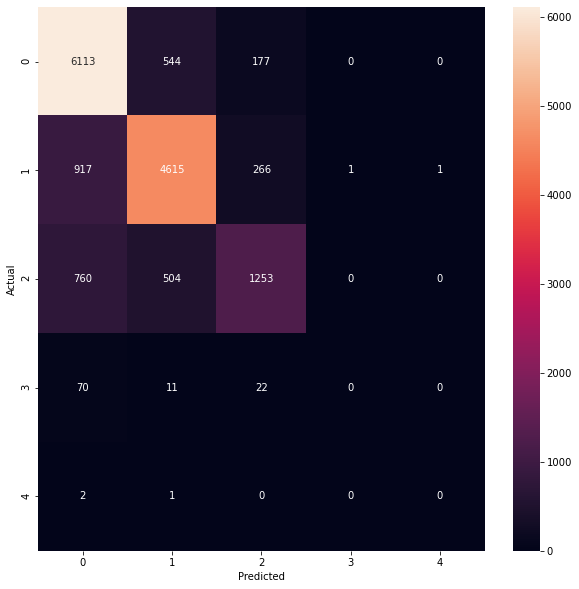

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6834
           1       0.81      0.80      0.80      5800
           2       0.73      0.50      0.59      2517
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00         3

    accuracy                           0.79     15257
   macro avg       0.46      0.44      0.45     15257
weighted avg       0.78      0.79      0.78     15257

Cohen Kappa Score          0.6475375700166737


In [33]:
LogRegOH7 = lin_mod.LogisticRegression(fit_intercept = 0, solver = 'lbfgs', class_weight = {0: 0.682, 1: 0.377 , 2: 0.166, 3: 0.006, 4: 0}, max_iter = 400, penalty = 'l2'
                                    , multi_class = 'auto')
LogRegOH7.fit(os_X, os_Y)
Y_predOH7 = LogRegOH7.predict(X_test)

Y_scoreOH7 = LogRegOH7.predict_proba(X_test)

cm = metrics.confusion_matrix(Y_testOH7, Y_predOH7)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(Y_testOH7, Y_predOH7))
print('Cohen Kappa Score         ',metrics.cohen_kappa_score(Y_testOH7, Y_predOH7))

Initial review of the LeftField model with correction coefficient applied

In [34]:
Y_score = pd.DataFrame(Y_scoreOH7, columns = ['Out', 'Single', 'Double', 'Triple', 'HomeRun'])
Y_score = np.around(Y_score, decimals = 4)

LF = pd.DataFrame(X_test, columns = cols7)
LF['OutPredProb'] = Y_score['Out']
LF['SinglePredProb'] = Y_score['Single']
LF['DoublePredProb'] = Y_score['Double']
LF['TriplePredProb'] = Y_score['Triple']
LF['HomeRunPredProb'] = Y_score['HomeRun']
LF['BasesScore'] = (LF['SinglePredProb'] + (LF['DoublePredProb'] * 2) + (LF['TriplePredProb'] * 3) + (LF['HomeRunPredProb'] * 4))
LF['BasesPred'] = Y_predOH7
LF['Bases'] = Y_testOH7
LF['Residual'] = LF['BasesScore'] - LF['Bases'] 

LFcc = LF['Bases'].sum() / LF['BasesScore'].sum()
LF['AdjBasesScore'] = ((LF['SinglePredProb'] * LFcc) + (LF['DoublePredProb'] * 2 * LFcc) + (LF['TriplePredProb'] * 3 * LFcc) + (LF['HomeRunPredProb'] * 4 * LFcc))


print('Total Bases in Test Set   ',LF['Bases'].sum())
print('Total Bases Predicted     ',LF['BasesPred'].sum())
print('Total Bases via Prob      ',LF['BasesScore'].sum())
print('Total Samples in Test Set ',len(LF))
print('Correction Coefficient    ',LFcc)
print('Total AdjBases Probability',LF['AdjBasesScore'].sum())
print('                                                   ')
coefficients = pd.DataFrame(LogRegOH7.coef_, columns = cols7)
print(coefficients)

Total Bases in Test Set    11155
Total Bases Predicted      9118
Total Bases via Prob       12175.218499999999
Total Samples in Test Set  15257
Correction Coefficient     0.916205323132394
Total AdjBases Probability 11155.000000000002
                                                   
   SprayAngle      Xloc  LineDrive   FlyBall     PopUp  FastBall  CurveBall  \
0    0.767059 -0.705464   5.943361  6.915997 -0.193068 -0.007194   0.018437   
1   -1.333236  2.429742  -1.674173 -3.609250 -4.279843 -0.004436  -0.004674   
2   -0.129384 -1.204284  -1.232438 -1.699268 -2.758382  0.013964  -0.019107   
3    0.485357 -0.386673  -1.513356 -0.803045  3.338778  0.002960   0.000246   
4    0.210204 -0.133321  -1.523394 -0.804434  3.892514 -0.005295   0.005098   

   ChangeUp  OtherPitch  Pitchhand   Batside  
0 -0.003096   -0.024391   0.001013  0.252549  
1  0.003228    0.019062   0.021317 -0.128232  
2  0.002730    0.006191  -0.038950 -0.233966  
3 -0.003476   -0.000422   0.011049  0.057833  
4  

We similarly create models for CenterField and RightField respectfully.  There's a balance between trying to increase accuracy, but keep the model as simplistic and intuitive as possible.  A Cohen Kappa Score was introduced to also help judge goodness of fit.  Models tested all were in the "moderate" category (0.6 - 0.8).  When features could be removed without much change to these scores, they were kept out.  

A correction coefficient was also calculated with these models.  This is needed because the expected bases using probabilities is showing a much higher value than actual bases.  That's not unexpected, especially with a model that does not capture extra base hits as well as hoped.  But this correction coefficient will allow a better scaled analysis and give us a line to plot to know who is above or below average.

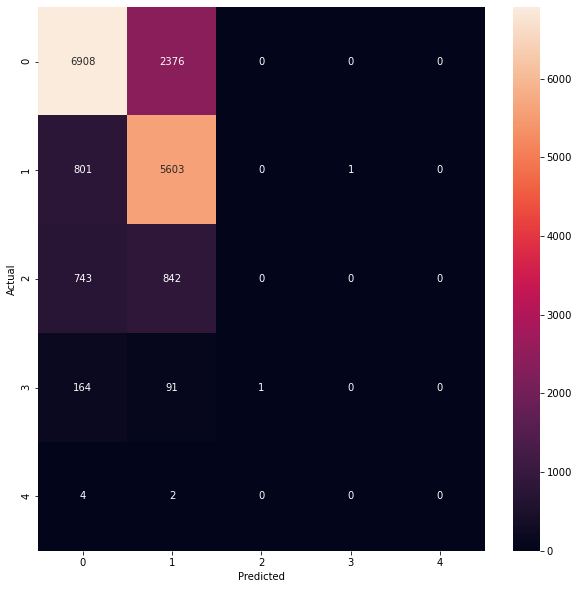

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      9284
           1       0.63      0.87      0.73      6405
           2       0.00      0.00      0.00      1585
           3       0.00      0.00      0.00       256
           4       0.00      0.00      0.00         6

    accuracy                           0.71     17536
   macro avg       0.29      0.32      0.30     17536
weighted avg       0.65      0.71      0.68     17536

Cohen Kappa Score          0.4828344064919664


In [35]:
OH8 = AHr.copy()
OH8 = OH8[OH8['HitLocation'] == 8]

OH8X = OH8.drop(columns = ['Bases','LeftLine','LeftCenter','Center','RightCenter','RightLine','GroundBall','Yloc','PitchSpeed','LaunchSpeed','LaunchAngle','HitLocation' 
                          ])
OH8Y = OH8['Bases'].to_numpy()

stand_X = preprocessing.scale(OH8X)

X_train, X_test, Y_train, Y_testOH8 = mod_sel.train_test_split(stand_X, OH8Y, test_size = .2, random_state = 27)

os = SMOTE(random_state = 27)
cols8 = OH8X.columns
os_X, os_Y = os.fit_sample(X_train, Y_train)

# {0: 0.682, 1: 0.211, 2: 0.065, 3: 0.007, 4: 0.045} AH
# {0: 0.493, 1: 0.367, 2: 0.126, 3: 0.014, 4: 0.000} OH
# {0: 0.682, 1: 0.377, 2: 0.166, 3: 0.006, 4: 0.000} OH7
# {0: 0.530, 1: 0.361, 2: 0.094, 3: 0.015, 4: 0.000} OH8
# {0: 0.510, 1: 0.365, 2: 0.124, 3: 0.021, 4: 0.000} OH9
LogRegOH8 = lin_mod.LogisticRegression(fit_intercept = 0, solver = 'lbfgs', class_weight = {0: 0.530, 1: 0.361, 2: 0.094, 3: 0.015, 4: 0.000}, max_iter = 400, penalty = 'l2'
                                    , multi_class = 'auto')
LogRegOH8.fit(os_X, os_Y)
Y_predOH8 = LogRegOH8.predict(X_test)
Y_scoreOH8 = LogRegOH8.predict_proba(X_test)

cm = metrics.confusion_matrix(Y_testOH8, Y_predOH8)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(Y_testOH8, Y_predOH8))
print('Cohen Kappa Score         ',metrics.cohen_kappa_score(Y_testOH8, Y_predOH8))

In [36]:
Y_score = pd.DataFrame(Y_scoreOH8, columns = ['Out', 'Single', 'Double', 'Triple', 'HomeRun'])
Y_score = np.around(Y_score, decimals = 4)

CF = pd.DataFrame(X_test, columns = cols8)
CF['OutPredProb'] = Y_score['Out']
CF['SinglePredProb'] = Y_score['Single']
CF['DoublePredProb'] = Y_score['Double']
CF['TriplePredProb'] = Y_score['Triple']
CF['HomeRunPredProb'] = Y_score['HomeRun']
CF['BasesScore'] = (CF['SinglePredProb'] + (CF['DoublePredProb'] * 2) + (CF['TriplePredProb'] * 3) + (CF['HomeRunPredProb'] * 4))
CF['BasesPred'] = Y_predOH8
CF['Bases'] = Y_testOH8
CF['Residual'] = CF['BasesScore'] - CF['Bases'] 

CFcc = CF['Bases'].sum() / CF['BasesScore'].sum()

CF['AdjBasesScore'] = ((CF['SinglePredProb'] * CFcc) + (CF['DoublePredProb'] * 2 * CFcc) + (CF['TriplePredProb'] * 3 * CFcc) + (CF['HomeRunPredProb'] * 4 * CFcc))


print('Total Bases in Test Set   ',CF['Bases'].sum())
print('Total Bases Predicted     ',CF['BasesPred'].sum())
print('Total Bases via Prob      ',CF['BasesScore'].sum())
print('Total Samples in Test Set ',len(CF))
print('Correction Coefficient    ',CFcc)
print('Total AdjBases Probability',CF['AdjBasesScore'].sum())
print('                                                   ')
coefficients = pd.DataFrame(LogRegOH8.coef_, columns = cols8)
print(coefficients)

Total Bases in Test Set    10367
Total Bases Predicted      8919
Total Bases via Prob       12456.725999999999
Total Samples in Test Set  17536
Correction Coefficient     0.8322411522899357
Total AdjBases Probability 10367.0
                                                   
   SprayAngle      Xloc  LineDrive   FlyBall  PopUp  FastBall  CurveBall  \
0    0.071924 -0.073546   6.588709  7.736807    0.0  0.005819  -0.009342   
1    0.993360 -1.004699  -2.908942 -5.468276    0.0 -0.030379   0.029740   
2   -0.413173  0.231928   0.916948  0.980344    0.0  0.024450  -0.029885   
3   -0.940826  1.134158  -2.101050 -1.502960    0.0  0.000273   0.006836   
4    0.288715 -0.287842  -2.495666 -1.745915    0.0 -0.000163   0.002650   

   ChangeUp  OtherPitch  Pitchhand   Batside  
0 -0.011016   -0.014665  -0.011193 -0.002420  
1  0.010904   -0.005760   0.020787 -0.003084  
2  0.001570    0.037076  -0.013519 -0.025972  
3 -0.001638   -0.012982   0.006019  0.030204  
4  0.000180   -0.003669  -0.002

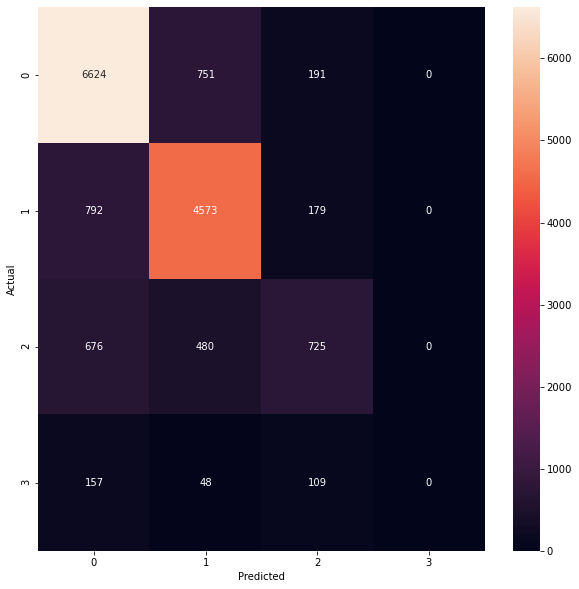

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      7566
           1       0.78      0.82      0.80      5544
           2       0.60      0.39      0.47      1881
           3       0.00      0.00      0.00       314

    accuracy                           0.78     15305
   macro avg       0.55      0.52      0.53     15305
weighted avg       0.75      0.78      0.76     15305

Cohen Kappa Score          0.6224057183046747


In [37]:
OH9 = AHr.copy()
OH9 = OH9[OH9['HitLocation'] == 9]

OH9X = OH9.drop(columns = ['Bases','LeftLine','LeftCenter','Center','RightCenter','RightLine','GroundBall','Yloc','PitchSpeed','LaunchSpeed','LaunchAngle','HitLocation' 
                          ])
OH9Y = OH9['Bases'].to_numpy()

stand_X = preprocessing.scale(OH9X)

X_train, X_test, Y_train, Y_testOH9 = mod_sel.train_test_split(stand_X, OH9Y, test_size = .2, random_state = 27)

os = SMOTE(random_state = 27)
cols9 = OH9X.columns
os_X, os_Y = os.fit_sample(X_train, Y_train)

# {0: 0.682, 1: 0.211, 2: 0.065, 3: 0.007, 4: 0.045} AH
# {0: 0.493, 1: 0.367, 2: 0.126, 3: 0.014, 4: 0.000} OH
# {0: 0.682, 1: 0.377, 2: 0.166, 3: 0.006, 4: 0.000} OH7
# {0: 0.530, 1: 0.361, 2: 0.094, 3: 0.015, 4: 0.000} OH8
# {0: 0.510, 1: 0.365, 2: 0.124, 3: 0.021, 4: 0.000} OH9
LogRegOH9 = lin_mod.LogisticRegression(fit_intercept = 0, solver = 'lbfgs', class_weight = {0: 0.510, 1: 0.365, 2: 0.124, 3: 0.021, 4: 0.000}, max_iter = 400, penalty = 'l2'
                                    , multi_class = 'auto')
LogRegOH9.fit(os_X, os_Y)
Y_predOH9 = LogRegOH9.predict(X_test)
Y_scoreOH9 = LogRegOH9.predict_proba(X_test)

cm = metrics.confusion_matrix(Y_testOH9, Y_predOH9)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(Y_testOH9, Y_predOH9))
print('Cohen Kappa Score         ',metrics.cohen_kappa_score(Y_testOH9, Y_predOH9))

In [38]:
Y_score = pd.DataFrame(Y_scoreOH9, columns = ['Out', 'Single', 'Double', 'Triple', 'HomeRun'])
Y_score = np.around(Y_score, decimals = 4)

RF = pd.DataFrame(X_test, columns = cols9)
RF['OutPredProb'] = Y_score['Out']
RF['SinglePredProb'] = Y_score['Single']
RF['DoublePredProb'] = Y_score['Double']
RF['TriplePredProb'] = Y_score['Triple']
RF['HomeRunPredProb'] = Y_score['HomeRun']
RF['BasesScore'] = (RF['SinglePredProb'] + (RF['DoublePredProb'] * 2) + (RF['TriplePredProb'] * 3) + (RF['HomeRunPredProb'] * 4))
RF['BasesPred'] = Y_predOH9
RF['Bases'] = Y_testOH9
RF['Residual'] = RF['BasesScore'] - RF['Bases'] 

RFcc = RF['Bases'].sum() / RF['BasesScore'].sum()

RF['AdjBasesScore'] = ((RF['SinglePredProb'] * RFcc) + (RF['DoublePredProb'] * 2 * RFcc) + (RF['TriplePredProb'] * 3 * RFcc) + (RF['HomeRunPredProb'] * 4 * RFcc))


print('Total Bases in Test Set   ',RF['Bases'].sum())
print('Total Bases Predicted     ',RF['BasesPred'].sum())
print('Total Bases via Prob      ',RF['BasesScore'].sum())
print('Total Samples in Test Set ',len(RF))
print('Correction Coefficient    ',RFcc)
print('Total AdjBases Probability',RF['AdjBasesScore'].sum())
print('                                                   ')
coefficients = pd.DataFrame(LogRegOH9.coef_, columns = cols9)
print(coefficients)

Total Bases in Test Set    10248
Total Bases Predicted      8260
Total Bases via Prob       12454.2586
Total Samples in Test Set  15305
Correction Coefficient     0.822851068790237
Total AdjBases Probability 10248.0
                                                   
   SprayAngle      Xloc  LineDrive   FlyBall     PopUp  FastBall  CurveBall  \
0   -0.524119  0.522810   6.100832  7.133482  2.262405  0.014068  -0.007401   
1    1.559781 -2.475333  -1.887616 -3.782765 -4.584321  0.009568  -0.004512   
2   -0.332315  1.201599  -1.108559 -1.445276 -2.070023 -0.010993  -0.005372   
3   -0.647590  0.803187  -1.495593 -0.947720  2.194336 -0.017066   0.018967   
4   -0.055757 -0.052262  -1.609063 -0.957721  2.197604  0.004422  -0.001681   

   ChangeUp  OtherPitch  Pitchhand   Batside  
0 -0.011469    0.008035  -0.004626 -0.249805  
1  0.000764   -0.020782  -0.021675  0.087608  
2  0.018188    0.001956   0.029580  0.206184  
3 -0.005635    0.015326   0.004225  0.011656  
4 -0.001849   -0.00453

ROC were created for each of the three models if a "one versus all" classification system was taken.  Outs and Singles look reasonably well with this approach with Doubles not being too back. Triples are difficult to predict and Home Runs very poor due to a small number in both the sample and population.  The macro avg line may be the most useful to consider since it takes into account all the different classes.

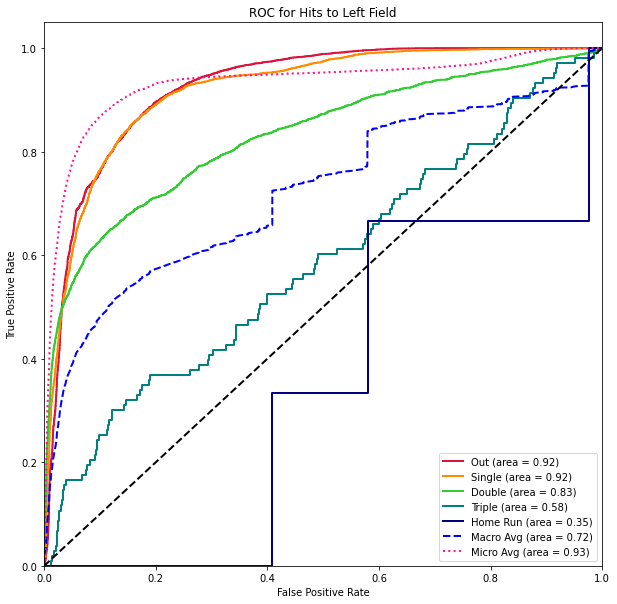

In [39]:
#https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Y_testLF = preprocessing.label_binarize(Y_testOH7, classes = [0, 1, 2, 3, 4])

n_classes = 5
fpr = dict()
tpr = dict()
roc_aucLF = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y_testLF[:, i], Y_scoreOH7[:, i])
    roc_aucLF[i] = metrics.auc(fpr[i], tpr[i])

fpr['micro'], tpr['micro'], _ = metrics.roc_curve(Y_testLF.ravel(), Y_scoreOH7.ravel())
roc_aucLF['micro'] = metrics.auc(fpr['micro'], tpr['micro'])    

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_aucLF['macro'] = metrics.auc(fpr['macro'], tpr['macro'])

plt.figure(figsize = (10,10))
lw = 2
plt.plot(fpr[0], tpr[0], color = 'crimson',
         lw = lw, label = 'Out (area = %0.2f)' % roc_aucLF[0])
plt.plot(fpr[1], tpr[1], color = 'darkorange',
         lw = lw, label = 'Single (area = %0.2f)' % roc_aucLF[1])
plt.plot(fpr[2], tpr[2], color = 'limegreen',
         lw = lw, label = 'Double (area = %0.2f)' % roc_aucLF[2])
plt.plot(fpr[3], tpr[3], color = 'teal',
         lw = lw, label = 'Triple (area = %0.2f)' % roc_aucLF[3])
plt.plot(fpr[4], tpr[4], color = 'navy',
         lw = lw, label = 'Home Run (area = %0.2f)' % roc_aucLF[4])
plt.plot(fpr['macro'], tpr['macro'], color = 'blue', linestyle = '--',
         lw = lw, label = 'Macro Avg (area = %0.2f)' % roc_aucLF['macro'])
plt.plot(fpr['micro'], tpr['micro'], color='deeppink', linestyle=':',
         lw = lw, label = 'Micro Avg (area = %0.2f)' % roc_aucLF['micro'])
plt.plot([0, 1], [0, 1], color = 'black', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Hits to Left Field')
plt.legend(loc = 'lower right')
plt.show()

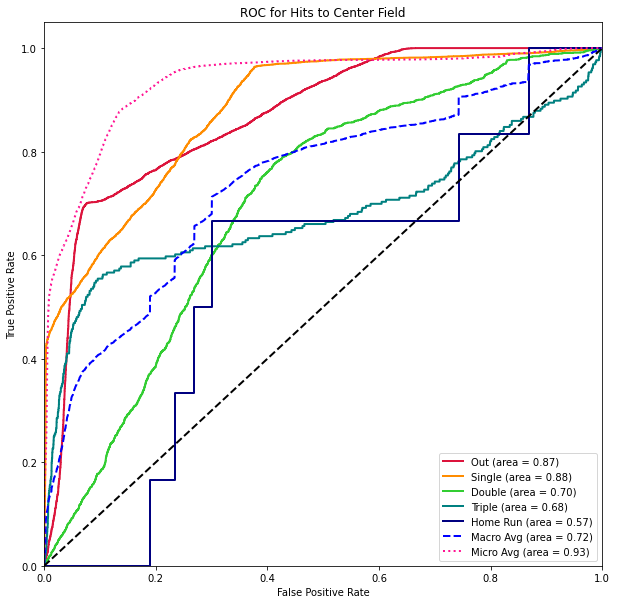

In [40]:
Y_testCF = preprocessing.label_binarize(Y_testOH8, classes = [0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_aucCF = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y_testCF[:, i], Y_scoreOH8[:, i])
    roc_aucCF[i] = metrics.auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], _ = metrics.roc_curve(Y_testCF.ravel(), Y_scoreOH8.ravel())
roc_aucCF['micro'] = metrics.auc(fpr['micro'], tpr['micro'])    

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_aucCF['macro'] = metrics.auc(fpr['macro'], tpr['macro'])

plt.figure(figsize = (10,10))
lw = 2
plt.plot(fpr[0], tpr[0], color = 'crimson',
         lw = lw, label = 'Out (area = %0.2f)' % roc_aucCF[0])
plt.plot(fpr[1], tpr[1], color = 'darkorange',
         lw = lw, label = 'Single (area = %0.2f)' % roc_aucCF[1])
plt.plot(fpr[2], tpr[2], color = 'limegreen',
         lw = lw, label = 'Double (area = %0.2f)' % roc_aucCF[2])
plt.plot(fpr[3], tpr[3], color = 'teal',
         lw = lw, label = 'Triple (area = %0.2f)' % roc_aucCF[3])
plt.plot(fpr[4], tpr[4], color = 'navy',
         lw = lw, label = 'Home Run (area = %0.2f)' % roc_aucCF[4])
plt.plot(fpr['macro'], tpr['macro'], color = 'blue', linestyle = '--',
         lw = lw, label = 'Macro Avg (area = %0.2f)' % roc_aucLF['macro'])
plt.plot(fpr['micro'], tpr['micro'], color='deeppink', linestyle=':',
         lw = lw, label = 'Micro Avg (area = %0.2f)' % roc_aucLF['micro'])
plt.plot([0, 1], [0, 1], color = 'black', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Hits to Center Field')
plt.legend(loc = 'lower right')
plt.show()

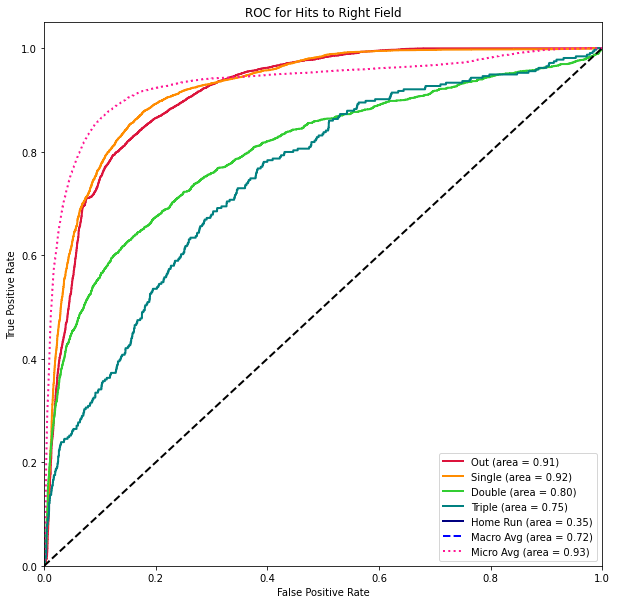

In [41]:
Y_testRF = preprocessing.label_binarize(Y_testOH9, classes = [0, 1, 2, 3, 4])

## RF
fpr = dict()
tpr = dict()
roc_aucRF = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y_testRF[:, i], Y_scoreOH9[:, i])
    roc_aucRF[i] = metrics.auc(fpr[i], tpr[i])
    
fpr['micro'], tpr['micro'], _ = metrics.roc_curve(Y_testRF.ravel(), Y_scoreOH9.ravel())
roc_aucRF['micro'] = metrics.auc(fpr['micro'], tpr['micro'])    

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_aucRF['macro'] = metrics.auc(fpr['macro'], tpr['macro'])

plt.figure(figsize = (10,10))
lw = 2
plt.plot(fpr[0], tpr[0], color = 'crimson',
         lw = lw, label = 'Out (area = %0.2f)' % roc_aucRF[0])
plt.plot(fpr[1], tpr[1], color = 'darkorange',
         lw = lw, label = 'Single (area = %0.2f)' % roc_aucRF[1])
plt.plot(fpr[2], tpr[2], color = 'limegreen',
         lw = lw, label = 'Double (area = %0.2f)' % roc_aucRF[2])
plt.plot(fpr[3], tpr[3], color = 'teal',
         lw = lw, label = 'Triple (area = %0.2f)' % roc_aucRF[3])
#plt.plot(fpr[4], tpr[4], color = 'navy',
#         lw = lw, label = 'Home Run (area = %0.2f)' % roc_aucLF[4])
plt.plot(fpr['macro'], tpr['macro'], color = 'blue', linestyle = '--',
         lw = lw, label = 'Macro Avg (area = %0.2f)' % roc_aucLF['macro'])
plt.plot(fpr['micro'], tpr['micro'], color='deeppink', linestyle=':',
         lw = lw, label = 'Micro Avg (area = %0.2f)' % roc_aucLF['micro'])
plt.plot([0, 1], [0, 1], color = 'black', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Hits to Right Field')
plt.legend(loc = 'lower right')
plt.show()

### Outfield Analysis

Using these contructed models, we can estimate how well or poor an outfielder at playing defense using the probability of an out, single, double, etc. vs what the actual result of the play was.  We will begin with the LeftFielders.  2019 data was purposedly left out from model creation, training, and test so it could run without any prior knowledge impacting results. 

Below code is passing the 2019 data through the saved regression model and then calculating the scores.  Errors are added back in to correct the actual bases that resulted in a fielder's error.  Fielders who had less than 162 balls hit to them, 1 per game, were removed from the corresponding visualization.  We also fill in any gaps that may have been missing data with a predicted bases score = actual bases. 

In [43]:
OH7a = AHa.copy()
OH7a = OH7a[OH7a['HitLocation'] == 7]
OH7b = OH7a.copy()

OH7a = OH7a.dropna(subset = ['LaunchAngle','LaunchSpeed', 'SprayAngle', 'PitchSpeed'])
OH7aX = OH7a[{'SprayAngle', 'Xloc', 'LineDrive', 'FlyBall', 'PopUp', 'FastBall', 'CurveBall', 'ChangeUp', 'OtherPitch', 'Pitchhand', 'Batside'}]
OH7aY = OH7a['Bases'].to_numpy()

stand_X = preprocessing.scale(OH7aX)

Y_predOH7a = LogRegOH7.predict(stand_X)
Y_scoreOH7a = LogRegOH7.predict_proba(stand_X)

OH7a['OutPredProb'] = Y_scoreOH7a[:,0]
OH7a['SinglePredProb'] = Y_scoreOH7a[:,1]
OH7a['DoublePredProb'] = Y_scoreOH7a[:,2]
OH7a['TriplePredProb'] = Y_scoreOH7a[:,3]
OH7a['HomeRunPredProb'] = Y_scoreOH7a[:,4]

OH7b['OutPredProb'] = OH7a['OutPredProb']
OH7b['SinglePredProb'] = OH7a['SinglePredProb']
OH7b['DoublePredProb'] = OH7a['DoublePredProb']
OH7b['TriplePredProb'] = OH7a['TriplePredProb']
OH7b['HomeRunPredProb'] = OH7a['HomeRunPredProb']
OH7b['BasesScore'] = (OH7b['SinglePredProb'] + (OH7b['DoublePredProb'] * 2) + (OH7b['TriplePredProb'] * 3) + (OH7b['HomeRunPredProb'] * 4))
OH7b['AdjBasesScore'] = OH7b['BasesScore'] * LFcc
OH7b['AdjBasesScore'] = OH7b['AdjBasesScore'].fillna(OH7b['Bases'])
OH7b['AdjBasesScore'] = OH7b['AdjBasesScore'] 
OH7b['Bases'] = OH7b['Bases'] + OH7b['Errors']
OH7b['BasesScore'] = OH7b['BasesScore'].fillna(OH7b['Bases'])
OH7b['BasesSaved'] = OH7b['AdjBasesScore'] - OH7b['Bases']

OH7c = OH7b.groupby('LeftFielder').filter(lambda x : len(x) > 162)

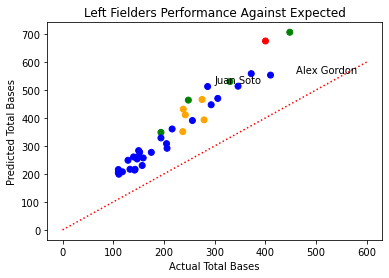

In [52]:
from matplotlib.colors import LinearSegmentedColormap

OH7e = OH7c.groupby(['LeftFielder']).sum().reset_index()

w7 = OH7e.sort_values(by=['BasesSaved']).head(5)  #worst
b7 = OH7e.sort_values(by=['BasesSaved'], ascending=False).head(5) #best

OH7e['cs'] = 1
OH7e.loc[OH7e.LeftFielder.isin([460086.0, 434158.0, 543257.0, 650391.0]), 'cs'] = 2
OH7e.loc[OH7e.LeftFielder.isin([502054.0, 668804.0, 606132.0, 596105.0, 444482.0]), 'cs'] = 0
OH7e.loc[OH7e.LeftFielder.isin([665742]), 'cs'] = 3

colors = ['orange', 'blue', 'green', 'red']
cmap1 = LinearSegmentedColormap.from_list('mycmap', colors)


plt.plot([0,600],[0,600], color = 'r', linestyle = 'dotted')
plt.scatter(OH7e['Bases'], OH7e['AdjBasesScore'], c = OH7e['cs'], cmap = cmap1);
plt.xlabel('Actual Total Bases')
plt.ylabel('Predicted Total Bases')
plt.title('Left Fielders Performance Against Expected')
plt.annotate('Juan Soto', [300, 525])
plt.annotate('Alex Gordon', [460, 561])
plt.show()

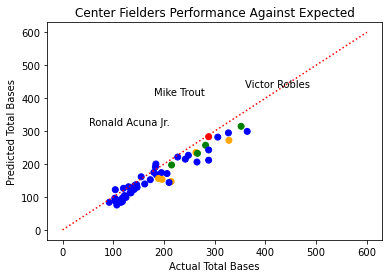

In [53]:
OH8a = AHa.copy()
OH8a = OH8a[OH8a['HitLocation'] == 8]
OH8b = OH8a.copy()

OH8a = OH8a.dropna(subset = ['LaunchAngle','LaunchSpeed', 'SprayAngle', 'PitchSpeed'])
OH8aX = OH8a[{'SprayAngle', 'Xloc', 'LineDrive', 'FlyBall', 'PopUp', 'FastBall', 'CurveBall', 'ChangeUp', 'OtherPitch', 'Pitchhand', 'Batside'}]
OH8aY = OH8a['Bases'].to_numpy()

stand_X = preprocessing.scale(OH8aX)

Y_predOH8a = LogRegOH8.predict(stand_X)
Y_scoreOH8a = LogRegOH8.predict_proba(stand_X)

OH8a['OutPredProb'] = Y_scoreOH8a[:,0]
OH8a['SinglePredProb'] = Y_scoreOH8a[:,1]
OH8a['DoublePredProb'] = Y_scoreOH8a[:,2]
OH8a['TriplePredProb'] = Y_scoreOH8a[:,3]
OH8a['HomeRunPredProb'] = Y_scoreOH8a[:,4]

OH8b['OutPredProb'] = OH8a['OutPredProb']
OH8b['SinglePredProb'] = OH8a['SinglePredProb']
OH8b['DoublePredProb'] = OH8a['DoublePredProb']
OH8b['TriplePredProb'] = OH8a['TriplePredProb']
OH8b['HomeRunPredProb'] = OH8a['HomeRunPredProb']
OH8b['BasesScore'] = (OH8b['SinglePredProb'] + (OH8b['DoublePredProb'] * 2) + (OH8b['TriplePredProb'] * 3) + (OH8b['HomeRunPredProb'] * 4))
OH8b['AdjBasesScore'] = OH8b['BasesScore'] * CFcc
OH8b['AdjBasesScore'] = OH8b['AdjBasesScore'].fillna(OH8b['Bases'])
OH8b['AdjBasesScore'] = OH8b['AdjBasesScore'] 
OH8b['Bases'] = OH8b['Bases'] + OH8b['Errors']
OH8b['BasesScore'] = OH8b['BasesScore'].fillna(OH8b['Bases'])
OH8b['BasesSaved'] = OH8b['AdjBasesScore'] - OH8b['Bases']

OH8c = OH8b.groupby('CenterFielder').filter(lambda x : len(x) > 162)

OH8e = OH8c.groupby(['CenterFielder']).sum().reset_index()

w8 = OH8e.sort_values(by=['BasesSaved']).head(5)  
b8 = OH8e.sort_values(by=['BasesSaved'], ascending = False).head(5) 

OH8e['cs'] = 1
OH8e.loc[OH8e.CenterFielder.isin([435622.0, 516782.0, 595281.0, 502481.0, 606466.0]), 'cs'] = 0
OH8e.loc[OH8e.CenterFielder.isin([660670.0, 645302.0, 622534.0, 592261.0]), 'cs'] = 2
OH8e.loc[OH8e.CenterFielder.isin([545361]), 'cs'] = 3


plt.plot([0,600],[0,600], color = 'r', linestyle = 'dotted')
plt.scatter(OH8e['Bases'], OH8e['AdjBasesScore'], c = OH8e['cs'], cmap = cmap1);
plt.xlabel('Actual Total Bases')
plt.ylabel('Predicted Total Bases')
plt.title('Center Fielders Performance Against Expected')
plt.annotate('Mike Trout', [180, 408])
plt.annotate('Ronald Acuna Jr.', [52, 318])
plt.annotate('Victor Robles', [360, 433])
plt.show()

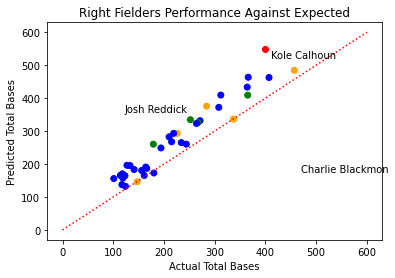

In [54]:
OH9a = AHa.copy()
OH9a = OH9a[OH9a['HitLocation'] == 9]
OH9b = OH9a.copy()

OH9a = OH9a.dropna(subset = ['LaunchAngle','LaunchSpeed', 'SprayAngle', 'PitchSpeed'])
OH9aX = OH9a[{'SprayAngle', 'Xloc', 'LineDrive', 'FlyBall', 'PopUp', 'FastBall', 'CurveBall', 'ChangeUp', 'OtherPitch', 'Pitchhand', 'Batside'}]
OH9aY = OH9a['Bases'].to_numpy()

stand_X = preprocessing.scale(OH9aX)

Y_predOH9a = LogRegOH9.predict(stand_X)
Y_scoreOH9a = LogRegOH9.predict_proba(stand_X)

OH9a['OutPredProb'] = Y_scoreOH9a[:,0]
OH9a['SinglePredProb'] = Y_scoreOH9a[:,1]
OH9a['DoublePredProb'] = Y_scoreOH9a[:,2]
OH9a['TriplePredProb'] = Y_scoreOH9a[:,3]
OH9a['HomeRunPredProb'] = Y_scoreOH9a[:,4]

OH9b['OutPredProb'] = OH9a['OutPredProb']
OH9b['SinglePredProb'] = OH9a['SinglePredProb']
OH9b['DoublePredProb'] = OH9a['DoublePredProb']
OH9b['TriplePredProb'] = OH9a['TriplePredProb']
OH9b['HomeRunPredProb'] = OH9a['HomeRunPredProb']
OH9b['BasesScore'] = (OH9b['SinglePredProb'] + (OH9b['DoublePredProb'] * 2) + (OH9b['TriplePredProb'] * 3) + (OH9b['HomeRunPredProb'] * 4))
OH9b['AdjBasesScore'] = OH9b['BasesScore'] * RFcc
OH9b['AdjBasesScore'] = OH9b['AdjBasesScore'].fillna(OH9b['Bases'])
OH9b['AdjBasesScore'] = OH9b['AdjBasesScore'] 
OH9b['Bases'] = OH9b['Bases'] + OH9b['Errors']
OH9b['BasesScore'] = OH9b['BasesScore'].fillna(OH9b['Bases'])
OH9b['BasesSaved'] = OH9b['AdjBasesScore'] - OH9b['Bases']

OH9c = OH9b.groupby('RightFielder').filter(lambda x : len(x) > 162)

OH9e = OH9c.groupby(['RightFielder']).sum().reset_index()

w9 = OH9e.sort_values(by=['BasesSaved']).head(5)  
b9 = OH9e.sort_values(by=['BasesSaved'], ascending = False).head(5) 

OH9e['cs'] = 1
OH9e.loc[OH9e.RightFielder.isin([453568.0, 592885.0, 518792.0, 451594.0, 430945.0]), 'cs'] = 0
OH9e.loc[OH9e.RightFielder.isin([502210.0, 608577.0, 596146.0, 624577.0]), 'cs'] = 2
OH9e.loc[OH9e.RightFielder.isin([594777]), 'cs'] = 3


plt.plot([0,600],[0,600], color = 'r', linestyle = 'dotted')
plt.scatter(OH9e['Bases'], OH9e['AdjBasesScore'], c = OH9e['cs'], cmap = cmap1);
plt.xlabel('Actual Total Bases')
plt.ylabel('Predicted Total Bases')
plt.title('Right Fielders Performance Against Expected')
plt.annotate('Kole Calhoun', [410, 520])
plt.annotate('Josh Reddick', [122, 357])
plt.annotate('Charlie Blackmon', [470, 176])
plt.show()

Further work could be to explore what characteristics make the best fielders different than the others.  And if there's anything in the model that is causing these to inflate some expected bases beyond what is expected would be interesting, but the best fielders identified by this approach is encouraging.